# Experiment 2: Defense Comparison - Intrinsic vs Extrinsic (CIFAR10)

## Experiment Goal
Compare **intrinsic defense** (model width) vs **extrinsic defense** (robust aggregation) to understand which provides better robustness against poisoning attacks.

## Research Questions
1. How does FedAvg compare to Median aggregation under poisoning?
2. Does model width complement or substitute for robust aggregation?
3. What is the optimal combination of width and aggregator?
4. Do defensive aggregators help more for narrow or wide models?

## 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Data Loading

In [2]:
RESULT_FILE = "./results_exp2_cifar10/final_results.csv"
OUTPUT_DIR = "./results_exp2_cifar10/plots"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    df = pd.read_csv(RESULT_FILE)
    print(f"✓ Data loaded successfully: {len(df)} rows")
    df.head()
except FileNotFoundError:
    print(f"❌ Error: File {RESULT_FILE} not found.")

✓ Data loaded successfully: 6 rows


## 3. Data Overview

In [3]:
print("Dataset Shape:", df.shape)
print("\nAggregators:", df['aggregator'].unique())
print("Width Factors:", sorted(df['width_factor'].unique()))
print("Poison Ratios:", sorted(df['poison_ratio'].unique()))

df.describe()

Dataset Shape: (6, 20)

Aggregators: ['fedavg' 'median']
Width Factors: [np.int64(4)]
Poison Ratios: [np.float64(0.0), np.float64(0.3), np.float64(0.5)]


,width_factor,depth,poison_ratio,alpha,batch_size,mean_test_acc,std_test_acc,mean_test_loss,std_test_loss,mean_val_acc,std_val_acc,mean_val_loss,std_val_loss,num_parameters,best_epoch
count,6.0,6.0,6.000000,6.0,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000
mean,4.0,4.0,0.266667,100.0,128.0,0.585983,0.005104,1.183416,0.011573,0.589100,0.006210,1.189508,0.019641,3158.0,80.166667
std,0.0,0.0,0.225093,0.0,0.0,0.012710,0.002269,0.033690,0.009354,0.013230,0.004660,0.031779,0.008119,0.0,32.096210
min,4.0,4.0,0.000000,100.0,128.0,0.568967,0.002398,1.139703,0.004629,0.572133,0.001799,1.152298,0.008763,3158.0,44.000000
25%,4.0,4.0,0.075000,100.0,128.0,0.577925,0.003258,1.159270,0.005996,0.579433,0.002896,1.169713,0.016705,3158.0,57.000000
50%,4.0,4.0,0.300000,100.0,128.0,0.585350,0.005088,1.183369,0.009849,0.590000,0.005643,1.180711,0.018223,3158.0,76.000000
75%,4.0,4.0,0.450000,100.0,128.0,0.596725,0.006917,1.208055,0.010335,0.600517,0.007154,1.212795,0.021947,3158.0,98.750000
max,4.0,4.0,0.500000,100.0,128.0,0.600267,0.007873,1.226535,0.029901,0.602533,0.014539,1.233789,0.033248,3158.0,128.000000


## 4. Visualizations

### 4.1 Grouped Bar Chart: FedAvg vs Median

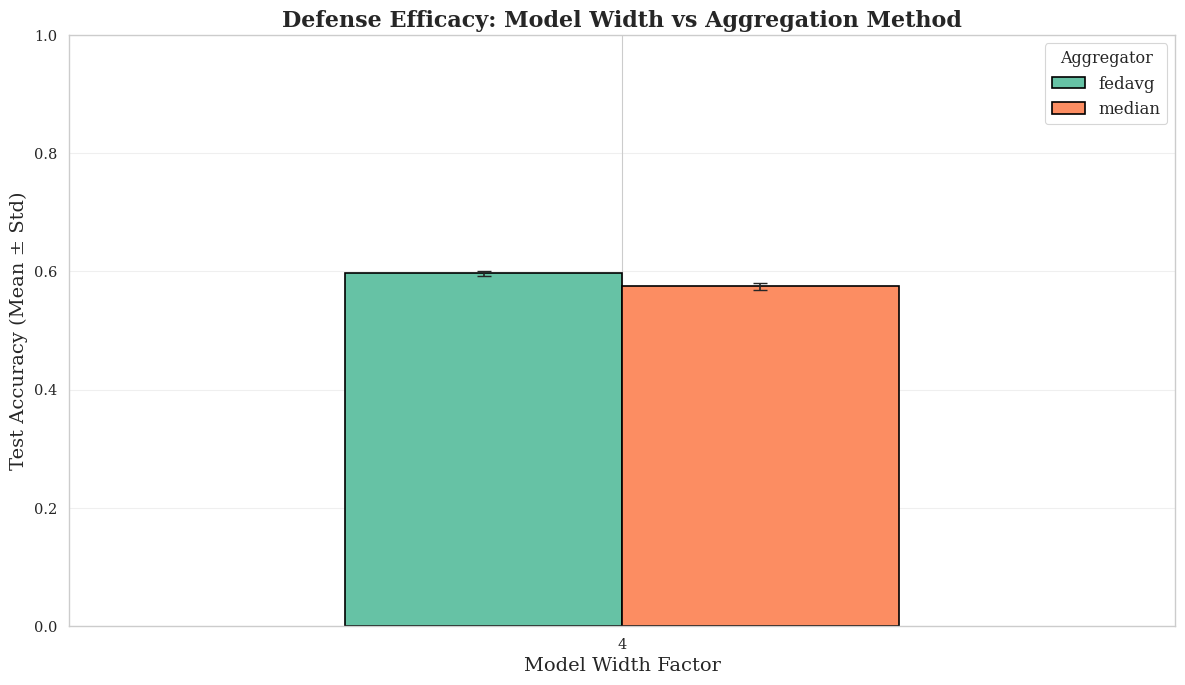

In [4]:
# Create pivot tables for plotting
pivot_mean = df.pivot_table(
    values='mean_test_acc',
    index='width_factor',
    columns='aggregator',
    aggfunc='mean'
)

pivot_std = df.pivot_table(
    values='std_test_acc',
    index='width_factor',
    columns='aggregator',
    aggfunc='mean'
)

# Plot with error bars
ax = pivot_mean.plot(
    kind='bar',
    yerr=pivot_std,
    capsize=5,
    rot=0,
    figsize=(12, 7),
    color=['#66c2a5', '#fc8d62'],
    edgecolor='black',
    linewidth=1.2
)

plt.title('Defense Efficacy: Model Width vs Aggregation Method', 
          fontsize=16, weight='bold')
plt.xlabel('Model Width Factor', fontsize=14)
plt.ylabel('Test Accuracy (Mean ± Std)', fontsize=14)
plt.legend(title='Aggregator', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/defense_comparison_bar.png")
plt.show()

### 4.2 Delta Plot: Median Improvement over FedAvg

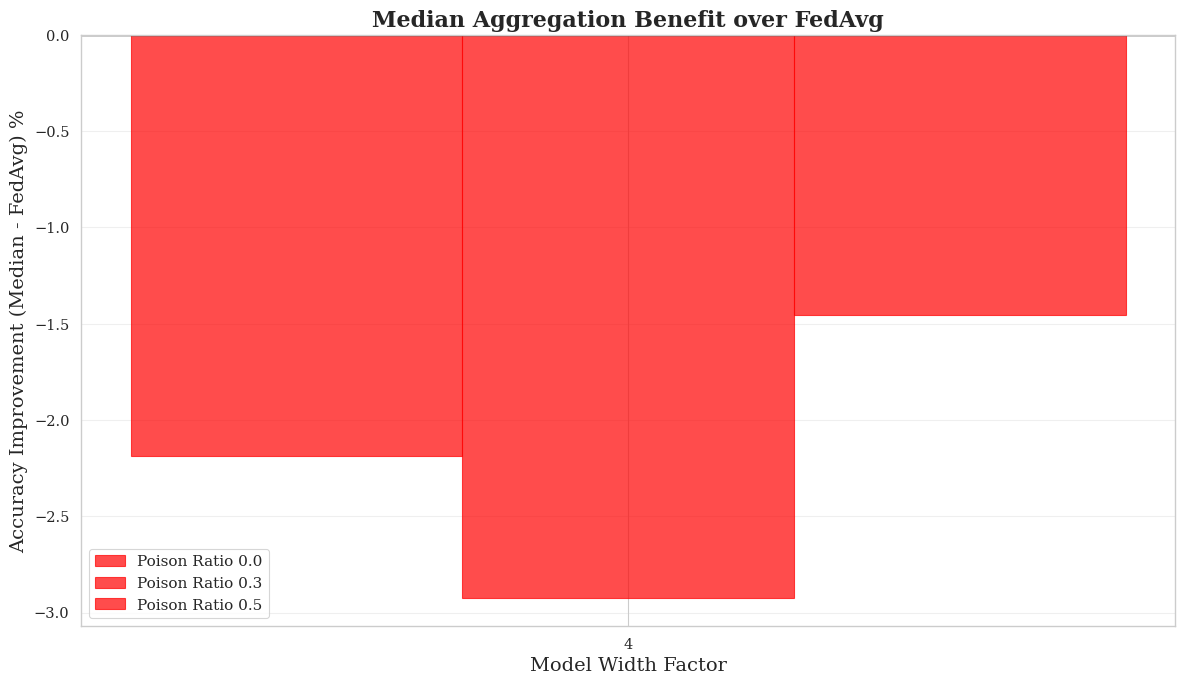

In [5]:
# Calculate improvement
improvement_data = []

for width in df['width_factor'].unique():
    for pr in df['poison_ratio'].unique():
        fedavg_acc = df[(df['width_factor'] == width) & 
                        (df['poison_ratio'] == pr) & 
                        (df['aggregator'] == 'fedavg')]['mean_test_acc'].values
        median_acc = df[(df['width_factor'] == width) & 
                        (df['poison_ratio'] == pr) & 
                        (df['aggregator'] == 'median')]['mean_test_acc'].values
        
        if len(fedavg_acc) > 0 and len(median_acc) > 0:
            improvement = median_acc[0] - fedavg_acc[0]
            improvement_data.append({
                'width_factor': width,
                'poison_ratio': pr,
                'improvement': improvement * 100  # Convert to percentage
            })

imp_df = pd.DataFrame(improvement_data)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

poison_ratios = sorted(imp_df['poison_ratio'].unique())
x = np.arange(len(imp_df['width_factor'].unique()))
width_bar = 0.25

for i, pr in enumerate(poison_ratios):
    subset = imp_df[imp_df['poison_ratio'] == pr].sort_values('width_factor')
    offset = (i - len(poison_ratios)/2 + 0.5) * width_bar
    bars = ax.bar(x + offset, subset['improvement'], width_bar, 
                  label=f'Poison Ratio {pr}')
    
    # Color bars: green if positive (median better), red if negative
    for bar, val in zip(bars, subset['improvement']):
        bar.set_color('green' if val > 0 else 'red')
        bar.set_alpha(0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Model Width Factor', fontsize=14)
ax.set_ylabel('Accuracy Improvement (Median - FedAvg) %', fontsize=14)
ax.set_title('Median Aggregation Benefit over FedAvg', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sorted(imp_df['width_factor'].unique()))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/median_improvement.png")
plt.show()

### 4.3 Heatmap: Aggregator × Width × Poison Ratio

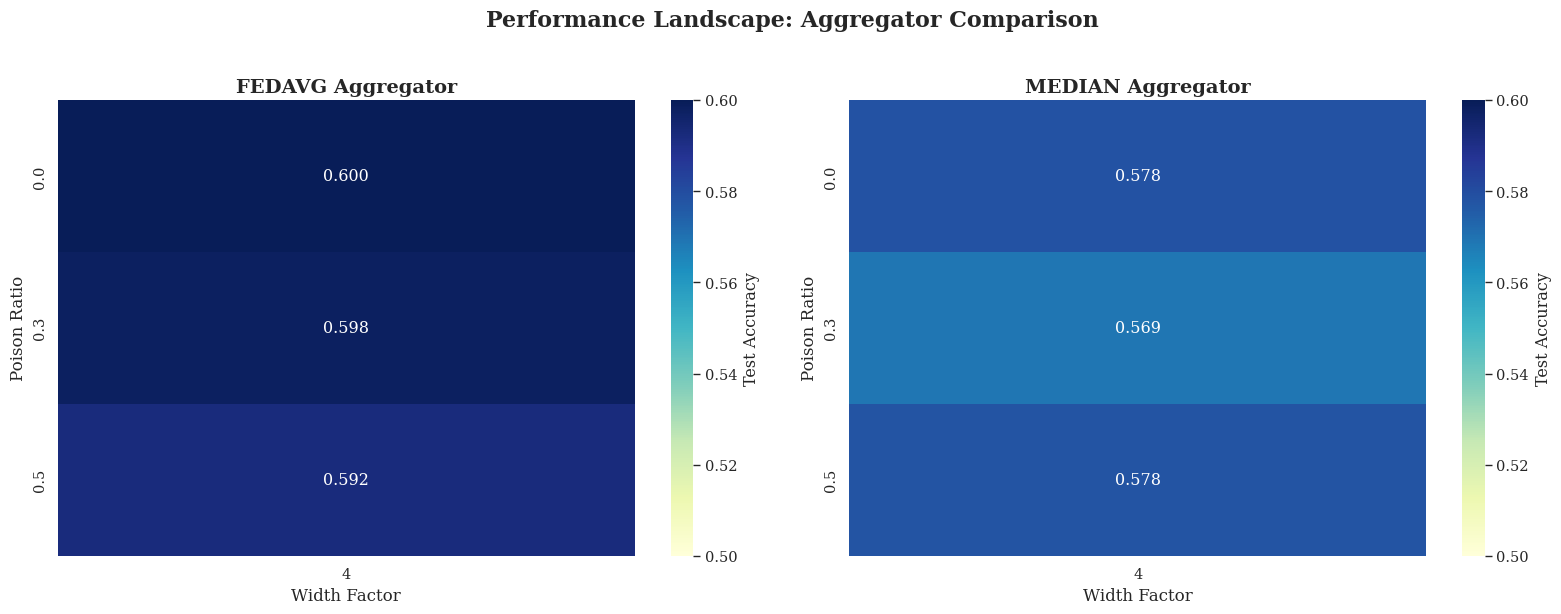

In [10]:
# Create separate heatmaps for each aggregator
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, agg in enumerate(['fedavg', 'median']):
    agg_data = df[df['aggregator'] == agg]
    pivot = agg_data.pivot_table(
        values='mean_test_acc',
        index='poison_ratio',
        columns='width_factor',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu',
                cbar_kws={'label': 'Test Accuracy'},
                vmin=0.5, vmax=0.6, ax=axes[idx])
    axes[idx].set_title(f'{agg.upper()} Aggregator', fontsize=14, weight='bold')
    axes[idx].set_xlabel('Width Factor', fontsize=12)
    axes[idx].set_ylabel('Poison Ratio', fontsize=12)

plt.suptitle('Performance Landscape: Aggregator Comparison', 
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/heatmap_aggregator_comparison.png")
plt.show()

## 5. General Observations

### Key Findings:

1. **Aggregation Method Impact**
   - Bar charts reveal magnitude of defense provided by Median vs FedAvg
   - Median aggregation acts as Byzantine-robust defense mechanism

2. **Width and Aggregator Interaction**
   - Delta plot shows whether defensive aggregators help more for narrow or wide models
   - Positive improvements indicate scenarios where Median excels

3. **Defense Complementarity**
   - Do intrinsic (width) and extrinsic (aggregation) defenses stack?
   - Or does one substitute for the other?

4. **Clean Performance Trade-off**
   - Check if Median aggregation hurts clean accuracy (poison_ratio=0)
   - Important for practical deployment where attacks are not always present

## 6. Mathematical Analysis

### 6.1 Defense Effectiveness Metric

Defense effectiveness $D_{\text{eff}}$ quantifies how well a defense maintains clean accuracy:

$$
D_{\text{eff}}(w, a, p) = \frac{\text{Acc}(w, a, p) - \text{Acc}_{\text{baseline}}(p)}{\text{Acc}_{\text{clean}}(w, a) - \text{Acc}_{\text{baseline}}(p)}
$$

where $w$ = width, $a$ = aggregator, $p$ = poison ratio, baseline = worst performing configuration.

### 6.2 Statistical Comparison: FedAvg vs Median

In [7]:
# Two-way ANOVA: Width × Aggregator interaction
from scipy.stats import f_oneway

# Test for each poison ratio
for pr in df['poison_ratio'].unique():
    print(f"\n{'='*60}")
    print(f"Poison Ratio: {pr}")
    print(f"{'='*60}")
    
    subset = df[df['poison_ratio'] == pr]
    
    fedavg_data = subset[subset['aggregator'] == 'fedavg']['mean_test_acc'].values
    median_data = subset[subset['aggregator'] == 'median']['mean_test_acc'].values
    
    if len(fedavg_data) > 0 and len(median_data) > 0:
        # T-test
        t_stat, p_value = stats.ttest_ind(median_data, fedavg_data)
        
        print(f"\nFedAvg: {fedavg_data.mean():.4f} ± {fedavg_data.std():.4f}")
        print(f"Median:  {median_data.mean():.4f} ± {median_data.std():.4f}")
        print(f"\nt-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            winner = "Median" if t_stat > 0 else "FedAvg"
            print(f"✓ {winner} is significantly better (p < 0.05)")
        else:
            print("✗ No significant difference (p >= 0.05)")


Poison Ratio: 0.0

FedAvg: 0.6003 ± 0.0000
Median:  0.5784 ± 0.0000

t-statistic: nan
p-value: nan
✗ No significant difference (p >= 0.05)

Poison Ratio: 0.3

FedAvg: 0.5982 ± 0.0000
Median:  0.5690 ± 0.0000

t-statistic: nan
p-value: nan
✗ No significant difference (p >= 0.05)

Poison Ratio: 0.5

FedAvg: 0.5923 ± 0.0000
Median:  0.5778 ± 0.0000

t-statistic: nan
p-value: nan
✗ No significant difference (p >= 0.05)


### 6.3 Effect Size (Cohen's d)

In [8]:
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

print("\nEffect Size (Cohen's d) - Median vs FedAvg:\n")
for pr in df['poison_ratio'].unique():
    subset = df[df['poison_ratio'] == pr]
    fedavg_data = subset[subset['aggregator'] == 'fedavg']['mean_test_acc'].values
    median_data = subset[subset['aggregator'] == 'median']['mean_test_acc'].values
    
    if len(fedavg_data) > 0 and len(median_data) > 0:
        d = cohens_d(median_data, fedavg_data)
        
        if abs(d) < 0.2:
            effect = "small"
        elif abs(d) < 0.8:
            effect = "medium"
        else:
            effect = "large"
        
        print(f"Poison Ratio {pr}: d = {d:+.3f} ({effect} effect)")


Effect Size (Cohen's d) - Median vs FedAvg:

Poison Ratio 0.0: d = +nan (large effect)
Poison Ratio 0.3: d = +nan (large effect)
Poison Ratio 0.5: d = +nan (large effect)


### 6.4 Interaction Analysis

Test if width and aggregator interact:

$$
\text{Interaction}(w, a) = \text{Acc}(w_{\text{large}}, a_{\text{robust}}) - \text{Acc}(w_{\text{small}}, a_{\text{robust}}) \\
- [\text{Acc}(w_{\text{large}}, a_{\text{baseline}}) - \text{Acc}(w_{\text{small}}, a_{\text{baseline}})]
$$

If interaction ≈ 0: effects are additive (complementary)

If interaction > 0: synergistic

If interaction < 0: one substitutes for the other

In [9]:
# Calculate interaction effect for poisoned scenarios
for pr in [p for p in df['poison_ratio'].unique() if p > 0]:
    wide_width = df['width_factor'].max()
    narrow_width = df['width_factor'].min()
    
    # Get accuracies
    acc_wide_median = df[(df['width_factor'] == wide_width) & 
                         (df['aggregator'] == 'median') & 
                         (df['poison_ratio'] == pr)]['mean_test_acc'].values
    acc_narrow_median = df[(df['width_factor'] == narrow_width) & 
                           (df['aggregator'] == 'median') & 
                           (df['poison_ratio'] == pr)]['mean_test_acc'].values
    acc_wide_fedavg = df[(df['width_factor'] == wide_width) & 
                         (df['aggregator'] == 'fedavg') & 
                         (df['poison_ratio'] == pr)]['mean_test_acc'].values
    acc_narrow_fedavg = df[(df['width_factor'] == narrow_width) & 
                           (df['aggregator'] == 'fedavg') & 
                           (df['poison_ratio'] == pr)]['mean_test_acc'].values
    
    if all(len(x) > 0 for x in [acc_wide_median, acc_narrow_median, 
                                  acc_wide_fedavg, acc_narrow_fedavg]):
        interaction = (acc_wide_median[0] - acc_narrow_median[0]) - \
                     (acc_wide_fedavg[0] - acc_narrow_fedavg[0])
        
        print(f"\nPoison Ratio {pr}:")
        print(f"  Interaction: {interaction:+.4f}")
        
        if abs(interaction) < 0.01:
            print("  → Additive (complementary defenses)")
        elif interaction > 0:
            print("  → Synergistic (combined defense better than sum)")
        else:
            print("  → Substitutive (one defense replaces the other)")


Poison Ratio 0.3:
  Interaction: +0.0000
  → Additive (complementary defenses)

Poison Ratio 0.5:
  Interaction: +0.0000
  → Additive (complementary defenses)


## 7. Conclusions

### Key Takeaways:

1. **Robust Aggregation Efficacy**
   - Median aggregation provides Byzantine-robust defense
   - Effect sizes quantify practical benefit magnitude

2. **Intrinsic vs Extrinsic Defense**
   - Model width (intrinsic) vs Median aggregation (extrinsic) comparison
   - Interaction analysis reveals if they complement or substitute each other

3. **Optimal Configuration**
   - Best combination of width and aggregator for robustness
   - Consider computational cost: Median is cheaper than wider models

4. **Clean Performance Impact**
   - Important to check Median doesn't hurt performance when there's no attack
   - Zero poison ratio results guide safe deployment

5. **Practical Recommendations**
   - Use Median aggregation as first line of defense (low cost)
   - Combine with moderate width for strong protection
   - Very wide models may not need robust aggregation (check interaction)

---

**Next Steps**: See Experiment 3 for mechanism analysis (batch size & ordering effects).